# Entrenamiento de la Red Neuronal

### Carga del dataset, SMOTE, escalado y split de los conjuntos train y test

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

data = pd.read_csv('dataset_preprocesado(1).csv')

data = data.dropna(subset=["N01"])

X = data.drop('TARGET', axis=1)

y = data['TARGET']

# Quitar filas con NaN en X
X = X.dropna()
y = y.loc[X.index]  # mantener sincronizados

# Aplicar SMOTE
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Escalar nuevamente los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

print('Training:', len(y_train), 'ejemplos | Validation:', len(y_test), 'ejemplos')


Training: 24806 ejemplos | Validation: 6202 ejemplos


### Función objetivo para Optuna

In [13]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 15.2 MB/s eta 0:00:00


In [14]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score

def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    units = [trial.suggest_int(f'n_units_l{i}', 32, 256) for i in range(n_layers)]
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2)

    model = Sequential()
    model.add(Dense(units[0], input_dim=X_train.shape[1], activation=activation,
                    kernel_regularizer=regularizers.l2(alpha)))
    model.add(Dropout(0.3))
    for u in units[1:]:
        model.add(Dense(u, activation=activation, kernel_regularizer=regularizers.l2(alpha)))
        model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=50, batch_size=64, verbose=0)

    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
    return f1_score(y_test, y_pred, average='macro')


### Optimización con Optuna

In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

print("Mejores hiperparámetros encontrados:")
print(study.best_params)


[I 2025-08-30 07:52:21,051] A new study created in memory with name: no-name-36a8985b-6a60-45e6-8981-d2ed8d547a9d
/tmp/ipython-input-2015088750.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-2015088750.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activit

Mejores hiperparámetros encontrados:
{'n_layers': 3, 'n_units_l0': 214, 'n_units_l1': 105, 'n_units_l2': 224, 'activation': 'relu', 'lr': 0.0011221117225044446, 'alpha': 0.00025595189520188195}


### Entrenamiento del modelo final con los hiperparámetros optimizados

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

# Hiperparámetros de Optuna
params = {
    'n_layers': 3,
    'n_units_l0': 214,
    'n_units_l1': 105,
    'n_units_l2': 224,
    'activation': 'relu',
    'lr': 0.0011221117225044446,
    'alpha': 0.00025595189520188195
}

model = Sequential()
model.add(Dense(params['n_units_l0'], activation=params['activation'],
                kernel_regularizer=regularizers.l2(params['alpha']),
                input_shape=(X_train.shape[1],)))

model.add(Dense(params['n_units_l1'], activation=params['activation'],
                kernel_regularizer=regularizers.l2(params['alpha'])))

model.add(Dense(params['n_units_l2'], activation=params['activation'],
                kernel_regularizer=regularizers.l2(params['alpha'])))

# Capa de salida (multiclase, suponiendo 3 clases)
model.add(Dense(3, activation='softmax'))

# Compilación
optimizer = Adam(learning_rate=params['lr'])
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    verbose=1
)


Epoch 1/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4347 - loss: 1.1147 - val_accuracy: 0.5005 - val_loss: 1.0249
Epoch 2/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5186 - loss: 1.0007 - val_accuracy: 0.5350 - val_loss: 0.9705
Epoch 3/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5433 - loss: 0.9464 - val_accuracy: 0.5576 - val_loss: 0.9278
Epoch 4/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5563 - loss: 0.9194 - val_accuracy: 0.5687 - val_loss: 0.9071
Epoch 5/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5732 - loss: 0.8960 - val_accuracy: 0.5630 - val_loss: 0.9122
Epoch 6/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5902 - loss: 0.8764 - val_accuracy: 0.5772 - val_loss: 0.8894
Epoch 7/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5854 - loss: 0.8732 - val_accuracy: 0.5945 - val_loss: 0.8753
Epoch 8/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6031 - loss: 0.8462 - val_accu

### Evaluación del modelo

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Accuracy final:", np.mean(y_pred == y_test))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Macro F1-Score:", f1_score(y_test, y_pred, average='macro'))


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy final: 0.6689777491131893

Matriz de confusión:
[[1435  396  236]
 [ 317 1178  572]
 [ 104  428 1536]]

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.77      0.69      0.73      2067
         1.0       0.59      0.57      0.58      2067
         2.0       0.66      0.74      0.70      2068

    accuracy                           0.67      6202
   macro avg       0.67      0.67      0.67      6202
weighted avg       0.67      0.67      0.67      6202

Macro F1-Score: 0.6689592931332804


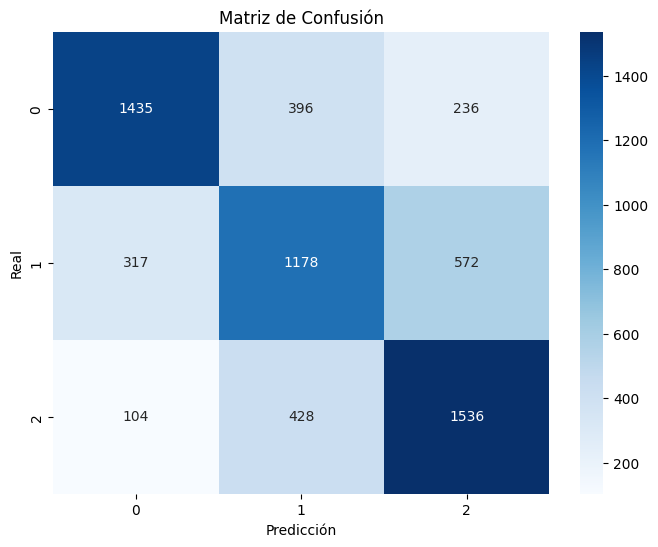

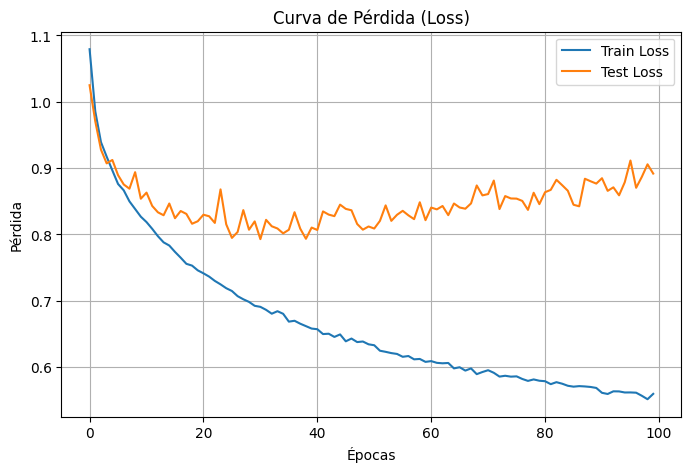

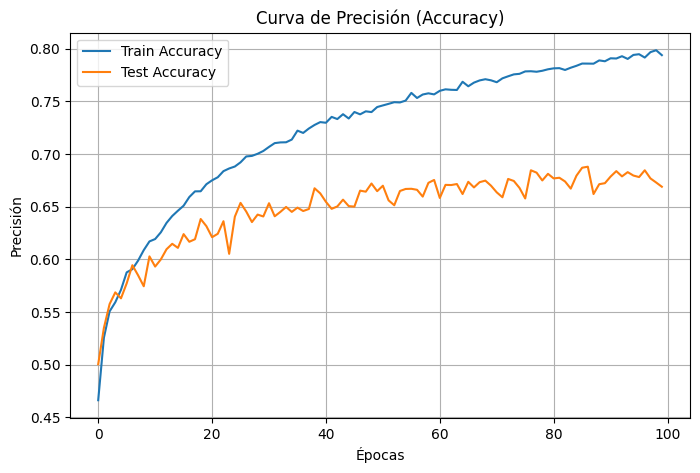

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva de pérdida
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de Pérdida (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# Curva de precisión
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Curva de Precisión (Accuracy)')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
#guardamos el modelo
# Guardar
model.save("modelo_anemia.h5")   # o formato .keras más nuevo

# Cargar
from tensorflow.keras.models import load_model
modelo_cargado = load_model("modelo_anemia.h5")
